<a href="https://colab.research.google.com/github/jery5237hent/Deep-Learning/blob/main/HW2_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch   
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.legacy import data
import spacy
import numpy as np
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
import random

SEED = 2021
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# !pip install spacy-transformers
# !python -m spacy download en_core_web_trf

In [ ]:
def accuracy(y_pred, y_test):
    pred = torch.argmax(y_pred, dim = 1, keepdim = True).squeeze(1)
    return (pred == y_test).sum()/len(y_test)

In [ ]:
def train(data, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for batch in data:
        optimizer.zero_grad()
        
        text, text_len = batch.title
        tag, tag_len = batch.pos_tag
        # print(tag)
        prediction, weights = model(text, tag)
        batch_loss = criterion(prediction, batch.category.squeeze(1))
        batch_acc = accuracy(prediction, batch.category.squeeze(1))

        batch_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.01)
        optimizer.step()
        scheduler.step()
        
        epoch_loss += batch_loss.item()
        epoch_acc += batch_acc.item()

    return epoch_loss / len(data), epoch_acc / len(data)

In [ ]:
def predict(data, model, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    ans = []
    
    with torch.no_grad():
        for batch in data:
            text, text_len = batch.title
            tag, tag_len = batch.pos_tag
            prediction, _ = model(text, tag)#.squeeze(1)
            pred = torch.argmax(prediction, dim = 1, keepdim = True).squeeze(1)
            ans.extend(list(map(lambda x: category.vocab.itos[x], pred)))
            
        return pd.DataFrame(ans, columns=['Category'])

In [ ]:
def evaluate(data, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in data:
            text, text_len = batch.title
            tag, tag_len = batch.pos_tag
            prediction, _ = model(text, tag)#.squeeze(1)

            batch_loss = criterion(prediction, batch.category.squeeze(1))
            batch_acc = accuracy(prediction, batch.category.squeeze(1))
            
            epoch_loss += batch_loss.item()
            epoch_acc += batch_acc.item()
        return epoch_loss / len(data), epoch_acc / len(data)

In [ ]:
def build_dict():
    category.build_vocab(train_data)
    title.build_vocab(train_data, test_data, vectors = GloVe(), unk_init=torch.Tensor.normal_)
    
    vocab = title.vocab
    vocab_size = len(title.vocab)
    n_class = len(category.vocab)
    
    PAD_IDX= vocab.stoi[title.pad_token]
    UNK_IDX = vocab.stoi[title.unk_token]

    vocab.vectors[UNK_IDX]=torch.zeros(vocab.vectors.shape[1])
    vocab.vectors[PAD_IDX]=torch.zeros(vocab.vectors.shape[1])
    
    return vocab_size, vocab, n_class

In [ ]:
def prepare_data(train, test):
    train = data.BucketIterator(
      (train),
      sort_key = lambda x: len(x.title),
      sort = True,
      sort_within_batch=True,
      batch_size = 256,
      device = device
    )

    test = data.BucketIterator(
      (test),
      batch_size = 256,
        sort = False,
        sort_within_batch=False,
        shuffle=False,
      device = device
    )
    
    return train, test

In [ ]:
def tag(text):
  return [token.pos_ for token in nlp(text)]

In [ ]:
df = pd.read_csv('news_data/train.csv')
df['Tag'] = df['Title']
df.to_csv('news_data/train.csv', index = False)

df = pd.read_csv('news_data/test.csv')
df['Tag'] = df['Title']
df.to_csv('news_data/test.csv', index = False)

In [ ]:
nlp = spacy.load('en_core_web_trf')
stop_words = nlp.Defaults.stop_words
category = data.Field(batch_first=True, pad_token=None, unk_token=None) 
title = data.Field(tokenize='spacy', tokenizer_language='en_core_web_trf', fix_length=12, #stop_words=stop_words, 
                   batch_first=True, lower= True, include_lengths=True, init_token='<sos>', eos_token='<eos>')

tagging = data.Field(tokenize=tag, tokenizer_language='en_core_web_trf', fix_length=12, #stop_words=stop_words, 
                   batch_first=True, include_lengths=True, init_token='<sos>', eos_token='<eos>')

train_data = data.TabularDataset(
   path = 'news_data/train.csv',
   format = 'csv',
   fields = [(None, None), ('category', category), ('title', title), ('pos_tag', tagging)],
   skip_header = True
)

test_data = data.TabularDataset(
   path = 'news_data/test.csv',
   format = 'csv',
   fields = [(None, None), ('title', title), ('pos_tag', tagging)],
   skip_header = True
)

# check an example
# print(vars(train_data[0]), vars(test_data[0]))
# print(vars(train_data[0]))

In [ ]:
train_set, valid_set = train_data.split(split_ratio=0.8, random_state=random.getstate())

In [ ]:
class Transformerlayer(nn.Module):
    def __init__(self):
    
        super(Transformerlayer, self).__init__()
        dropout = 0.1
        nheads = 2
        dim_feedforward = 1024
        
        self.embedding_dim = vocab.vectors.shape[1]
        self.attn = nn.MultiheadAttention(embed_dim = self.embedding_dim, dropout = dropout, num_heads = nheads)
        self.linear1 = nn.Linear(self.embedding_dim, dim_feedforward)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, self.embedding_dim)
        self.norm1 = nn.LayerNorm(self.embedding_dim)
        self.norm2 = nn.LayerNorm(self.embedding_dim)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        
    def forward(self, x, src_mask, padding_mask):
        x1, weights = self.attn(x, x, x, attn_mask=src_mask, key_padding_mask= padding_mask)
        x = x + self.dropout2(x1)
        x = self.norm1(x)
        x1 = self.linear2(self.dropout1(F.relu(self.linear1(x))))
        x = x + self.dropout3(x1)
        x = self.norm2(x)
        
        return x, weights

In [ ]:
class Transformer(nn.Module):
    def __init__(self):
    
        super(Transformer, self).__init__()

        self.n = 16
        self.embedding_dim = vocab.vectors.shape[1]
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        single_encoder = Transformerlayer()
        self.Encoder = nn.ModuleList([single_encoder for i in range(2)])
        self.Decoder = nn.Sequential(nn.Linear(self.embedding_dim + self.n, 256), nn.ReLU(), nn.Linear(256, n_class))
        self.pos = PositionalEncoding(self.embedding_dim)

        self.embedding1 = nn.Embedding(len(tagging.vocab), self.n)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.n, nhead=2, dim_feedforward=64)
        self.Encoder1 = nn.TransformerEncoder(encoder_layer, num_layers = 2)
        # self.Decoder1 = nn.Linear(tagging.vocab.shape[1], 20)
        self.pos1 = PositionalEncoding(self.n)

    def forward(self, text, tag):
#       embedding -> position -> transformer(encoder)  -> transformer(decoder)
        # padding_mask = (torch.zeros((outputs.shape[0], outputs.shape[1])) == vocab.stoi['<pad>']).to(device)

        outputs = (self.embedding(text)) * np.sqrt(self.embedding_dim) # (batch_size, title_len, embedding_dim)
        outputs = self.pos(outputs.transpose(0, 1)).to(device)  # (batch_size, title_len, embedding_dim)

        weights = []
        for m in self.Encoder:
            outputs, weight = m(outputs, None, None)
            weights.append(weight)

        outputs = outputs.transpose(0, 1)
        outputs = torch.mean(outputs, dim = 1)

        outputs1 = (self.embedding1(tag)) * np.sqrt(self.n) # (batch_size, title_len, embedding_dim)
        outputs1 = self.pos1(outputs1.transpose(0, 1)).to(device)  # (batch_size, title_len, embedding_dim)
        outputs1 = self.Encoder1(outputs1)
        outputs1 = outputs1.transpose(0, 1)

        outputs1 = torch.mean(outputs1, dim = 1)

        outputs = torch.cat((outputs, outputs1), 1)
        # print(outputs.shape)
        assert outputs.shape[-1] == self.embedding_dim + self.n
        # outputs = torch.mean(outputs, dim = 1)

        outputs = F.softmax(self.Decoder(outputs), dim=1)
        return outputs, weights

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=20):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (- np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x.to(device)
        x = x + (self.pe[:x.size(0), :]).to(device)
        return self.dropout(x)

In [ ]:
def plot_attention(text, tag):
    prediction, w = model(text, tag)
    pred = torch.argmax(prediction, dim = 1, keepdim = True).squeeze(1)
    
    print(f"Prediction : {category.vocab.itos[pred[-5]]}")
    text = text[-5].detach().cpu().numpy()

    plt.imshow(w[-1][-5].detach().cpu().numpy(), cmap = "gray", interpolation='none')
    plt.yticks(np.arange(len(text)), np.array(vocab.itos)[text])
    plt.xticks(np.arange(len(text)), np.array(vocab.itos)[text],
                rotation=45, ha="right",rotation_mode="anchor")
    plt.title(f'Multihead Attention Map')
    plt.show()

In [ ]:
tagging.build_vocab(train_data, test_data)

In [ ]:
N_EPOCHS = 75
best_loss = float('inf')
train_loss = train_acc = 0
l_train, acc_train = [], []
l_valid, acc_valid = [], []

vocab_size, vocab, n_class = build_dict()
model = Transformer().to(device)
# model.load_state_dict(torch.load('transformer_90990.pt'))

optimizer = optim.Adam(model.parameters(), lr=7e-3, betas=(0.9, 0.98), eps = 1e-9, weight_decay=1e-5)

# optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.98), eps = 1e-9)#, weight_decay=1e-6)

lambda_scheduler = lambda step: vocab.vectors.shape[1] ** (-0.5) * min(1/np.sqrt((step+1)), (step+1)* (150**(-1.5)))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)

criterion = nn.CrossEntropyLoss() #ignore_index = vocab.stoi['<pad>']
learning_rate = []
training_data, testing_data = prepare_data(train_set, valid_set)

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(training_data, optimizer, criterion)
    valid_loss, valid_acc = evaluate(testing_data, optimizer, criterion)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model = model
    
    acc_train.append(train_acc)
    l_train.append(train_loss)

    acc_valid.append(valid_acc)
    l_valid.append(valid_loss)

    learning_rate.append(optimizer.param_groups[0]['lr'])

    # if (epoch+1) % 5 == 0:
    print(f'Epoch: {epoch+1}')
    print('learning rate: ', optimizer.param_groups[0]['lr'])
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

Epoch: 1
learning rate:  1.5399214345840372e-06
	Train Loss: 1.611 | Train Acc: 20.69%
	Valid Loss: 1.612 | Valid Acc: 17.07%
Epoch: 2
learning rate:  2.859854092798926e-06
	Train Loss: 1.611 | Train Acc: 20.25%
	Valid Loss: 1.611 | Valid Acc: 18.55%
Epoch: 3
learning rate:  4.179786751013815e-06
	Train Loss: 1.610 | Train Acc: 21.16%
	Valid Loss: 1.610 | Valid Acc: 19.94%
Epoch: 4
learning rate:  5.499719409228704e-06
	Train Loss: 1.609 | Train Acc: 23.50%
	Valid Loss: 1.608 | Valid Acc: 23.78%
Epoch: 5
learning rate:  6.819652067443592e-06
	Train Loss: 1.607 | Train Acc: 25.49%
	Valid Loss: 1.606 | Valid Acc: 26.26%
Epoch: 6
learning rate:  8.13958472565848e-06
	Train Loss: 1.605 | Train Acc: 28.45%
	Valid Loss: 1.603 | Valid Acc: 29.43%
Epoch: 7
learning rate:  9.45951738387337e-06
	Train Loss: 1.602 | Train Acc: 31.36%
	Valid Loss: 1.600 | Valid Acc: 30.21%
Epoch: 8
learning rate:  1.077945004208826e-05
	Train Loss: 1.599 | Train Acc: 31.22%
	Valid Loss: 1.597 | Valid Acc: 31.19%
E

In [ ]:
# plt.plot(range(len(learning_rate)), learning_rate)

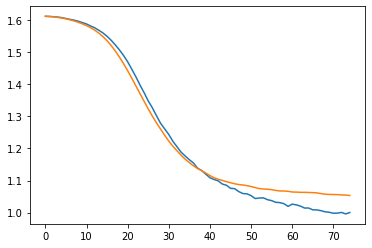

In [ ]:
plt.plot(l_train)
plt.plot(l_valid)

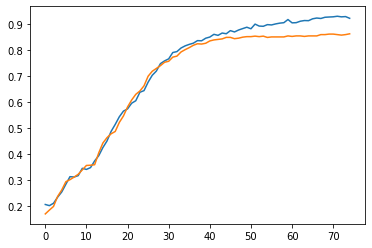

In [ ]:
plt.plot(acc_train)
plt.plot(acc_valid)

In [ ]:
training_data, testing_data = prepare_data(train_data, test_data)
# optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.98), eps = 1e-9, weight_decay=1e-5)

# lambda_scheduler = lambda step: vocab.vectors.shape[1] ** (-0.5) * min(1/np.sqrt((step+1)), (step+1)* (450**(-1.5)))
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)

# criterion = nn.CrossEntropyLoss()
# model = Transformer().to(device)
# for epoch in range(N_EPOCHS):
train(training_data, optimizer, criterion)

(1.0072281956672668, 0.9156634126390729)

In [ ]:
# training_data, testing_data = prepare_data(train_data, test_data)
# model = Transformer().to(device)
# model.load_state_dict(torch.load('transformer_test.pt'))

<All keys matched successfully>

In [ ]:
ans = predict(testing_data, best_model, optimizer, criterion)
ans.insert(0, column="Id", value = ans.index.values)
ans.to_csv('0852629_submission_transformer.csv', index = False)

In [ ]:
# torch.save(model.state_dict(), 'transformer_test.pt')

# Attention map

sport 

Prediction : sport


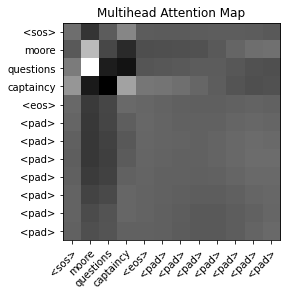

sport 

Prediction : sport


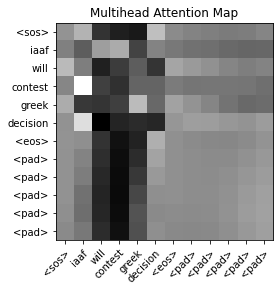

tech 

Prediction : tech


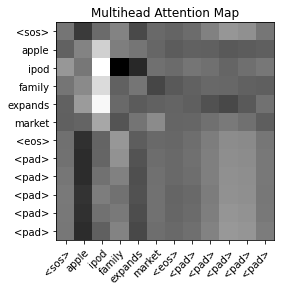

sport 

Prediction : sport


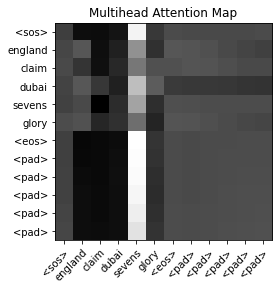

entertainment 

Prediction : sport


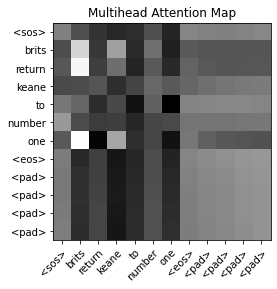

In [ ]:
cnt = 0
for batch in training_data:
    text, _ = batch.title
    tag, _ = batch.pos_tag
    label_idx = batch.category[-5].cpu().numpy()[0]

    print(category.vocab.itos[label_idx], '\n')
    plot_attention(text, tag)
    cnt += 1
    
    if cnt == 5: break